import functions

In [1]:

import  os,warnings, sys, shutil, torch, os, numpy as np, math
import pandas as pd


warnings.filterwarnings("ignore")
import pickle
import torch
path = os.path.dirname(os.getcwd())
# os.chdir('/workspaces/classification_yishai/transformers/')
# path = '/workspaces/classification_yishai/mutual_functions/'
sys.path.insert(0,path + '/mutual_functions/' )
data_path = path + '/mutual_functions/data/' 
from usefull_functions import *
from evaluation_functions import *
from plot_functions import *

from utils import training,initialize_training,tensor_dataset_transformers,test
from sklearn.metrics import  accuracy_score

# reload packages with new changes
%load_ext autoreload
%autoreload 2

data_path
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
torch.cuda.empty_cache()


model params

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)
prop = {'dataset':'AF', #'shortTracks_seperate.pkl
        'batch':15,
        'lr':0.001,  
        'epochs':500,#300

        'emb_size':64,#the feature dimension is transforemed to emb_size 
        'nhead':16, # number of heads in the multiheadattention models 
        # Note that embed_dim will be split across num_heads (i.e. each head will have dimension embed_dim // num_heads).
        
        'norm':'mean_standardize', #'MinMaxScale' # 'mean_standardize', 
        'seq_len':1000,#20, 
        'LEN':None, #None,#7
        'task_type':'classification', # 'classification' # 'regression'

        "nlayers":2,   'task_rate':0.5, 'masking_ratio':0.15, 
        'lamb':0.8, 'ratio_highest_attention':0.5, 'avg':'macro', 'dropout':0.01, 'nhid':128, 'nhid_task':128, 'nhid_tar':128,

        'device':device,
        'dtype':torch.half if 'cuda' in str(device) else torch.float32, #torch.half, #
        'data_path' : data_path,
        'get_attn_maps':False,
        
        


}

cpu


load and preprocess dataset

In [3]:
%load_ext autoreload
%autoreload 2
# prop['shuffle'] = False
# X_train, y_train, X_test, y_test,X_val,y_val = loadData(prop,prop['data_path'])
# print(f'{len(y_train)+len(y_test)+len(y_val)}{y_train},{y_test},{y_val}')
prop['shuffle'] = True
X_train1, y_train1, X_test1, y_test1,X_val1,y_val1 = loadData(prop,prop['data_path'])



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loading start...
'seq_len (n steps)': 640
train ind: (1, 10, 17, 29, 26, 23, 6, 0, 15, 18, 20, 28, 5, 8, 12)
test ind: (4, 24, 11, 2, 13, 25, 9, 7, 27, 3, 19, 14, 21, 16, 22)
0 :  5
0 :  5
1 :  5
1 :  5
2 :  5
2 :  5
data columns ['3', '2']
clssified by:  type
mean:  [-0.00670786  0.01775463]  std:  [0.25814643 0.08959018]  m1  (15, 2)  s1  (15, 2)
preprocessing data using mean_standardize complete...
X_train: (15, 640, 2), y_train: (15,), X_test: (15, 640, 2), y_test: (15,)


run model

In [4]:
%load_ext autoreload
%autoreload 2
def main(prop):
    # input: 
    #   x [np.float32, torch.tensor] - shape: (batch_size, seq_len, input_size)  
    #   y [np.float32, torch.tensor] - shape: (batch_size, nclasses) or (batch_size, seq_len, nclasses)
    X_train, y_train, X_test, y_test,_,_ = loadData(prop,prop['data_path'])

    # dataloader, data batches and transform into tensor
    X_train_task, y_train_task = tensor_dataset_transformers(prop, X_train, y_train,dtype = prop['dtype'])#allow to change the train_data dtype into half (float16)
    X_test, y_test = tensor_dataset_transformers(prop, X_test, y_test)
    prop['seq_len'], prop['input_size'] = X_train_task.shape[1], X_train_task.shape[2]
    print(X_train_task.shape, y_train_task.shape, X_test.shape, y_test.shape)  
    

    
    prop['nclasses'] = torch.max(y_train_task).item() + 1 if prop['task_type'] == 'classification' else None
    if np.unique(y_train_task.numpy()).shape[0] != prop['nclasses']: print ('nclasses not equal to the number of unique classes in the training set')
    
    print('Initializing model...')
    model, optimizer, criterion_tar, criterion_task, best_model, best_optimizer = initialize_training(prop)
    print('Model intialized...')

    print('Training start...')
    attention_maps,acc_arr = training(model, optimizer, criterion_tar, criterion_task, best_model, best_optimizer, X_train_task, y_train_task, X_test, y_test, prop)
    print('Training complete...')
    
    # y_pred, y, _, _, _, _, _ = test(best_model, X_test, y_test, prop['batch'], prop['nclasses'], criterion_task, prop['task_type'], prop['device'], prop['avg'])
    # pred, target = y_pred.cpu().data.numpy(), y.cpu().data.numpy()
    # pred = np.argmax(pred, axis = 1)
    # acc = accuracy_score(target, pred)
    # print(f'acc: {acc}')    
    return criterion_task,best_model,best_optimizer,attention_maps,acc_arr

criterion_task,best_model,best_optimizer,attention_maps,acc = main(prop)
# mat = []
# for i in range(20):
    
#     j = int(640-i*640/20)
#     prop['seq_len'] = j
#     # print(f' seq_len: {j}')
   
#     criterion_task,best_model,best_optimizer,attention_maps,acc = main(prop)
#     mat.append([prop['seq_len'],acc[-1],prop['epochs'],prop['batch'],prop['LEN'],acc])
#     pickle.dump(mat, open('accuarcyVSseq_len.pkl', 'wb'))
#     # plot_accuarcy('accuarcyVSseq_len.pkl')
    


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loading start...
'seq_len (n steps)': 640
train ind: (1, 10, 17, 29, 26, 23, 6, 0, 15, 18, 20, 28, 5, 8, 12)
test ind: (4, 24, 11, 2, 13, 25, 9, 7, 27, 3, 19, 14, 21, 16, 22)
0 :  5
0 :  5
1 :  5
1 :  5
2 :  5
2 :  5
data columns ['3', '2']
clssified by:  type
mean:  [-0.00670786  0.01775463]  std:  [0.25814643 0.08959018]  m1  (15, 2)  s1  (15, 2)
preprocessing data using mean_standardize complete...
X_train: (15, 640, 2), y_train: (15,), X_test: (15, 640, 2), y_test: (15,)
torch.Size([15, 640, 2]) torch.Size([15]) torch.Size([15, 640, 2]) torch.Size([15])
Initializing model...
Model intialized...
Training start...
Epoch: 1, TAR Loss: 2.5047260522842407 , TASK Loss: 0.981855571269989,epoch Acc: 0.3333333333333333


inference & analysis
1. prediction of test data
2. returns test_metrics: for classification [loss, acc, prec, rec, f1] else [rmse, mae]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
accuracy: 100.0,
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15

roc curve applicable only for binary classification (this is a multiclass classification)


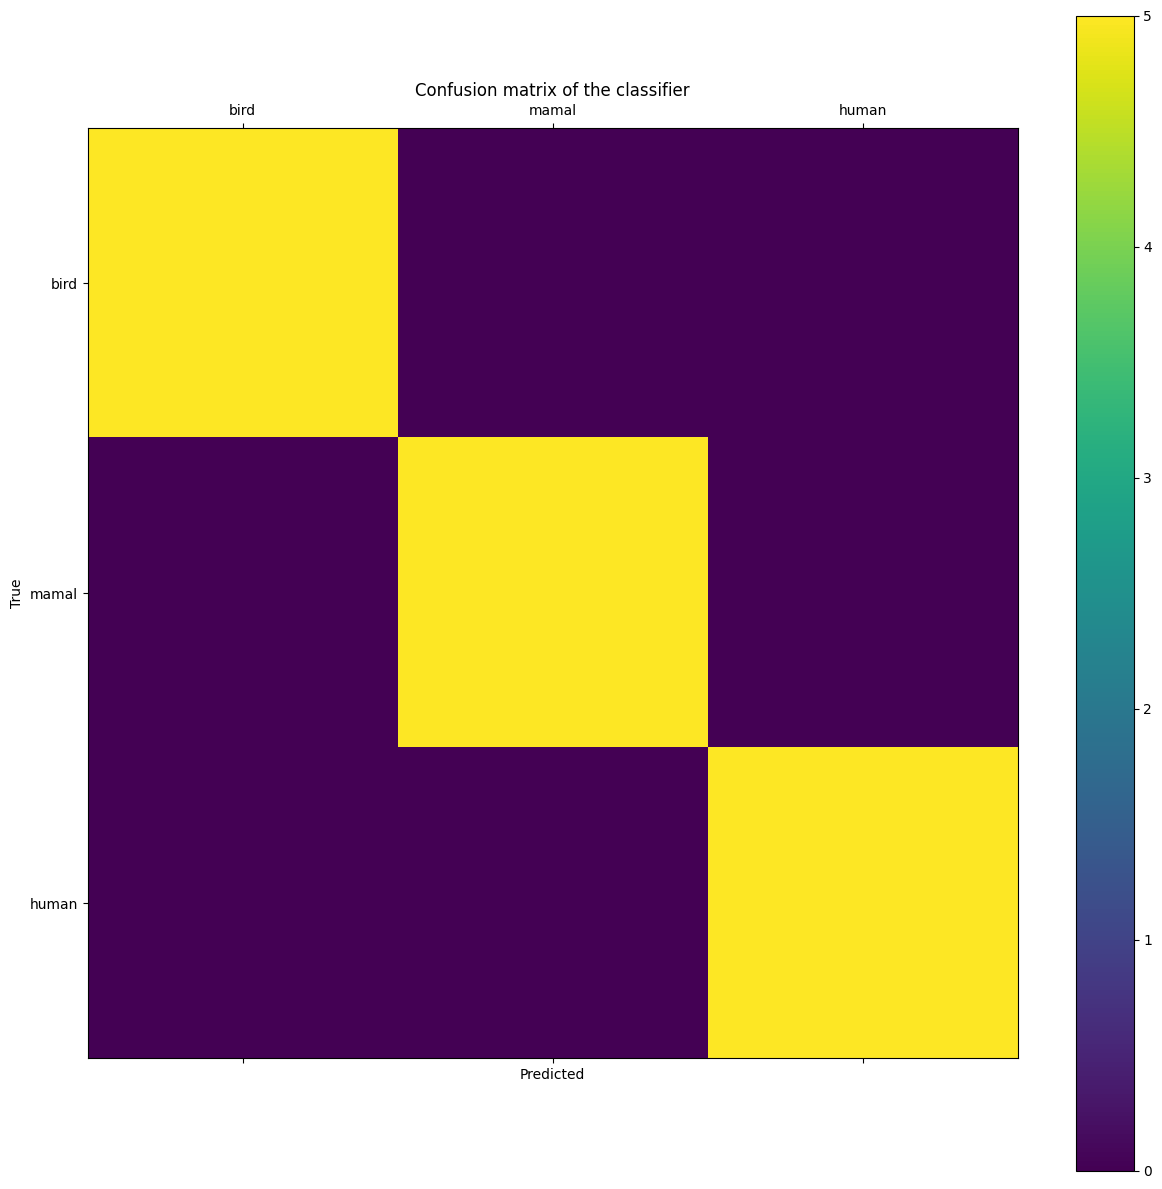

In [ ]:
%load_ext autoreload
%autoreload 2
X_train_task, y_train_task = tensor_dataset_transformers(prop, X_train, y_train)
X_test, y_test = tensor_dataset_transformers(prop, X_test, y_test)
# X_train_task, y_train_task, X_test, y_test = tensor_dataset_transformers(prop, X_train, y_train, X_test, y_test)
y_pred, y, _, _, _, _, _ = test(best_model, X_test, y_test, prop['batch'], prop['nclasses'], criterion_task, prop['task_type'], prop['device'], prop['avg'])
# test_metrics = utils.evaluate(y_pred, y, nclasses, criterion, task_type, device, avg)
# prop['class_names_'] = get_class_names(data_path + prop['dataset'] + '/class.csv',prop['class_names'].copy())
# prop['class_names']   
test_metrics = evaluate_(y_pred, y, prop['nclasses'], criterion_task, prop['task_type'], device,class_names = prop['class_names_'])

# print(test_metrics)



